In [276]:
# ******* Volatility Models **************
# author: R.Shyaam Prasadh Ph.D.
# Contents: 1) ARCH  
#           2) GARCH, GJR-GARCH and EGARCH model
#           3) SVR-GARCH -Linear, RBF and Polynominal
#           4) ## MLP-GARCH, DEEP LEARNING-GARCH

In [4]:
import os
os.environ["http_proxy"] = "http://internet.ford.com:83"
os.environ["https_proxy"] = "http://internet.ford.com:83"
os.environ["no_proxy"] = "localhost,ford.com,googleapis.com"
#!pip install --upgrade  yfinance
#!pip install --upgrade  pandas_datareader
#!pip install --upgrade  arch
#!pip install --upgrade  tensorflow

In [5]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [6]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [7]:
s_p500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
...,...,...,...,...,...,...
2021-07-26,4409.580078,4422.729980,4405.450195,4422.299805,4422.299805,4275630000
2021-07-27,4416.379883,4416.379883,4372.509766,4401.459961,4401.459961,4241950000
2021-07-28,4402.950195,4415.470215,4387.009766,4400.640137,4400.640137,4215290000


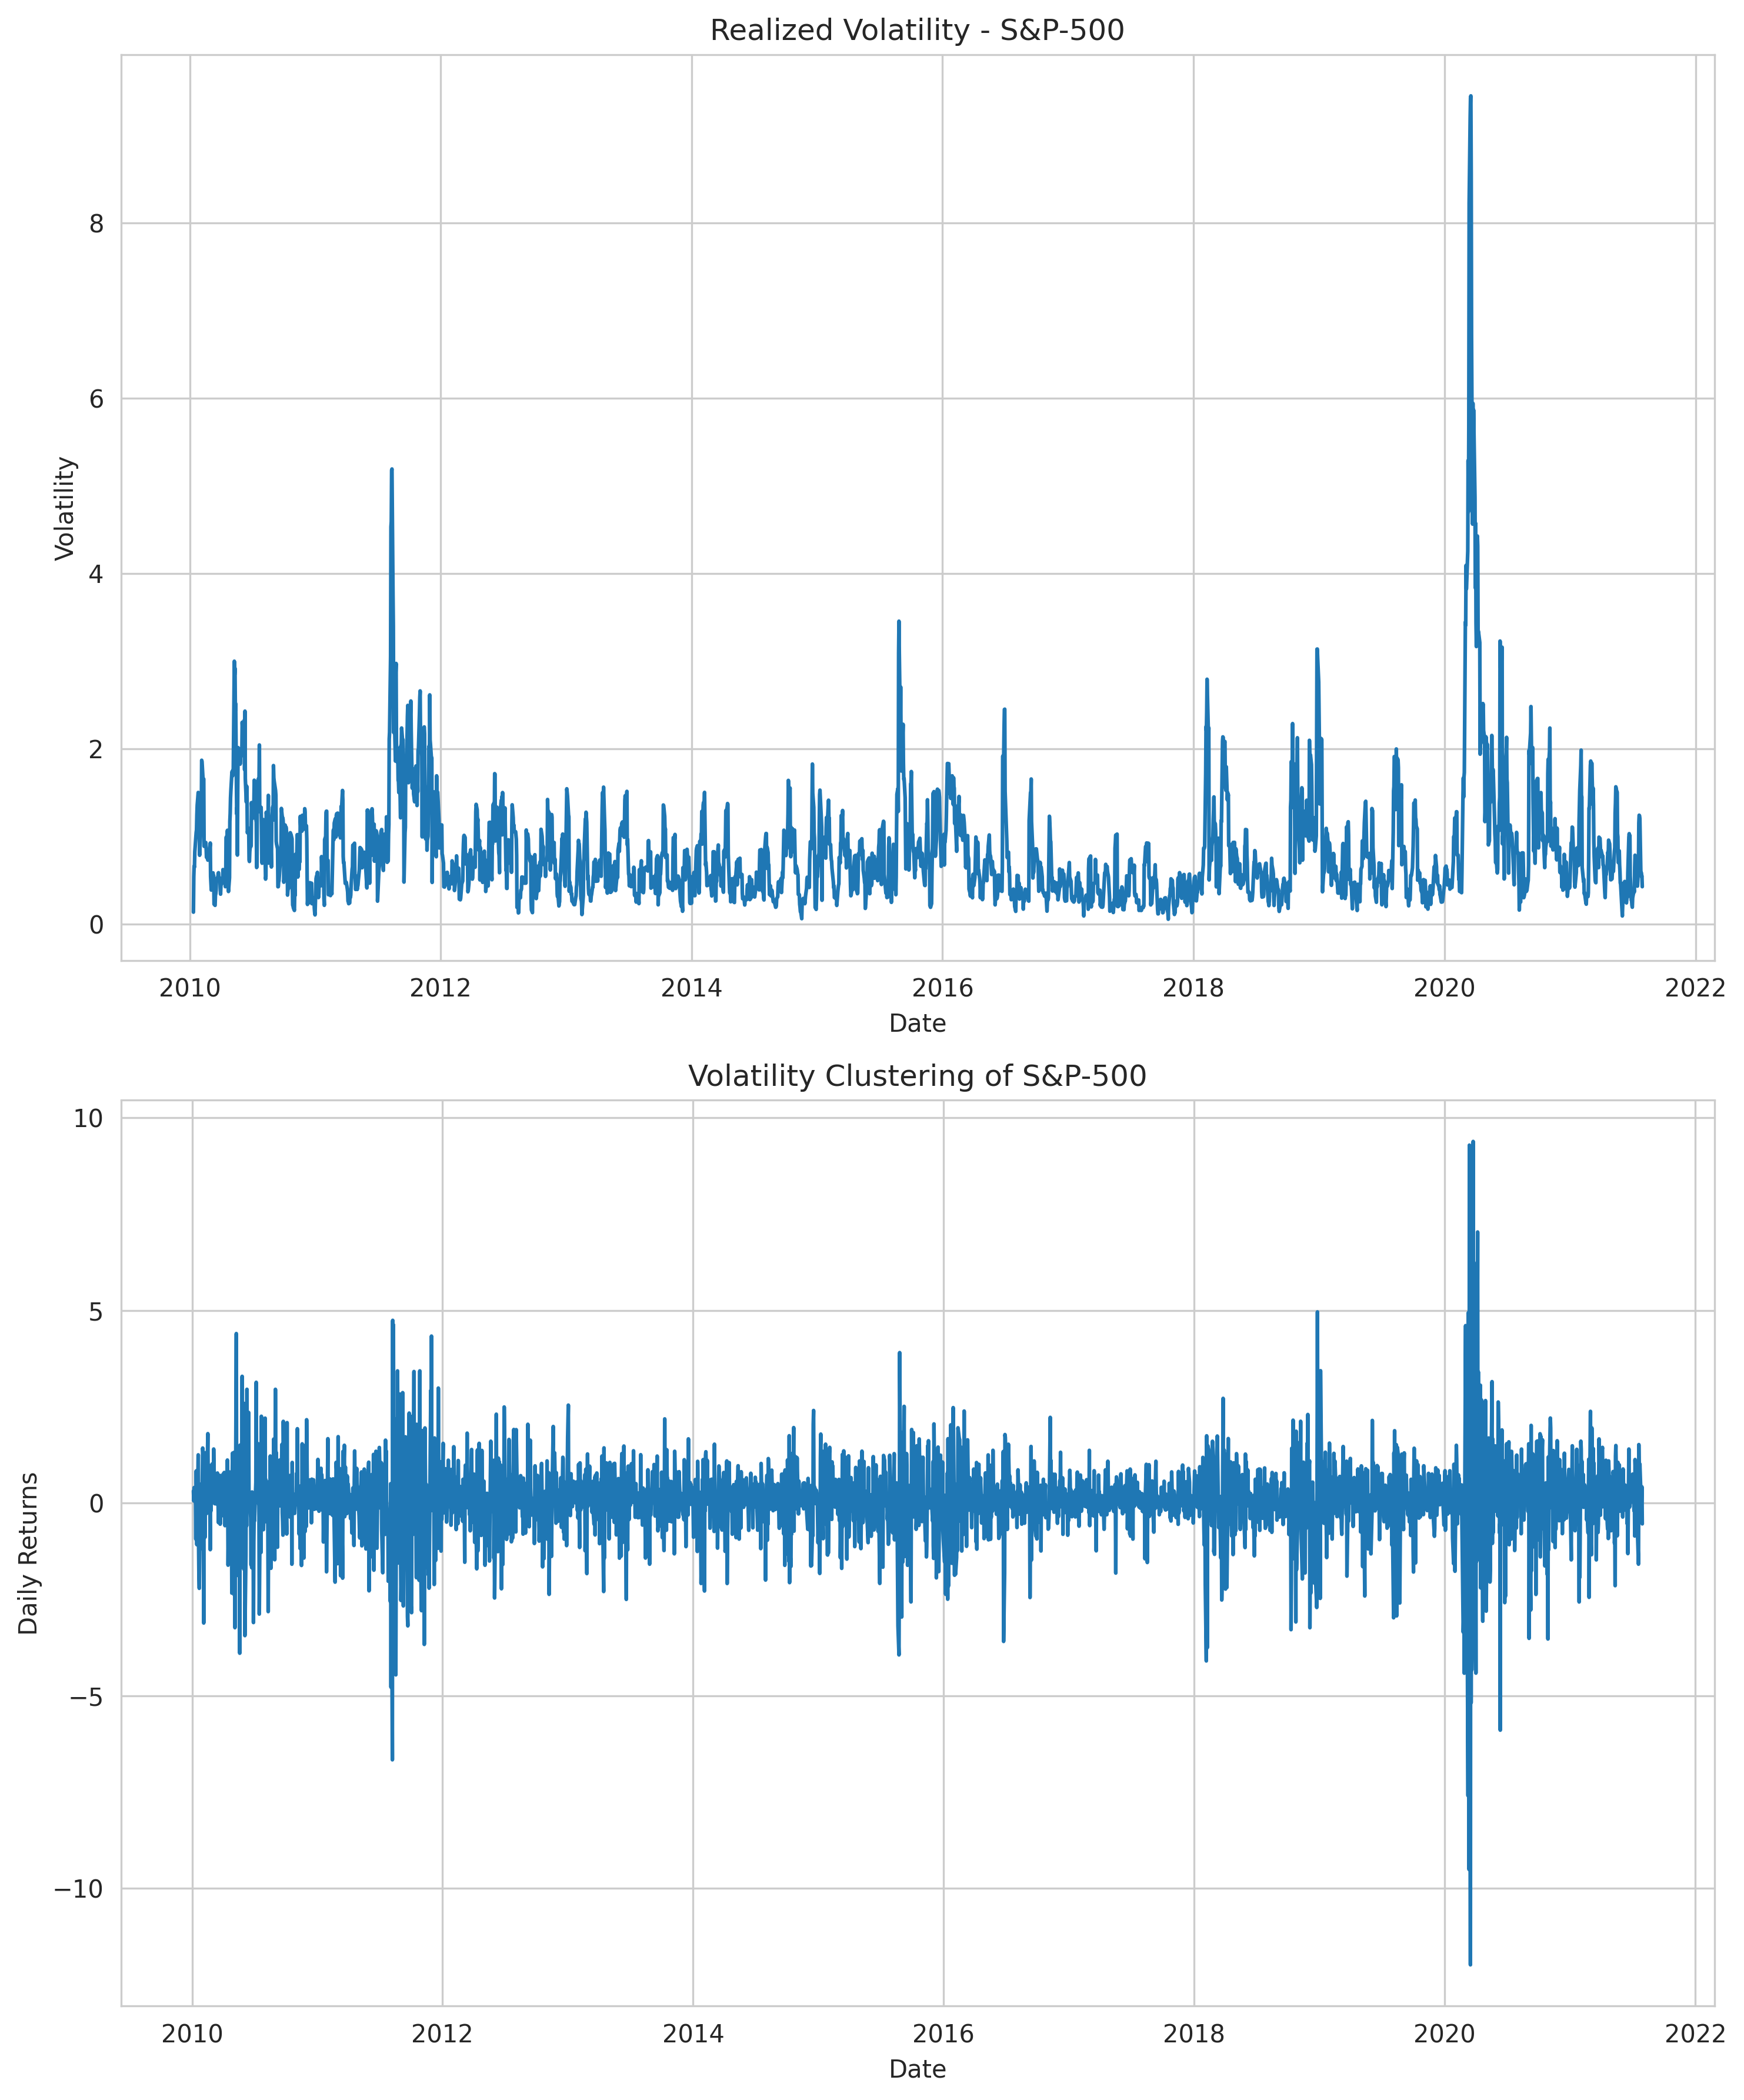

In [51]:
ret =100* s_p500['Adj Close'].pct_change().iloc[1:]
realized_vol = ret.rolling(window=5).std()
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
axes[0].plot(realized_vol.index, realized_vol)
axes[0].set(title='Realized Volatility - S&P-500', ylabel='Volatility', xlabel='Date')
retv = ret.values
axes[1].plot(s_p500.index[1:], retv)
axes[1].set(title='Volatility Clustering of S&P-500', ylabel='Daily Returns', xlabel='Date')
plt.tight_layout()
plt.show()

### Arch Model

In [53]:
n = 252
split_date = ret.iloc[-n:].index
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3 * sgm2 + np.sqrt(9 * sgm2 ** 2 - 12 * (3 * sgm2 - K) * K)) / (6 * K)
omega = (1 - alpha) * sgm2
initial_parameters = [alpha, omega]

print(f'Initial parameters: alpha = {alpha:.4f}, omega = {omega:.6f}')


Initial parameters: alpha = 0.4667, omega = 0.634156


In [54]:
@jit(nopython=True, parallel=True)
def arch_likelihood(initial_parameters, retv):
    omega = np.abs(initial_parameters[0])
    alpha = np.abs(initial_parameters[1])
    T = len(retv)
    logliks = 0.0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

logliks = arch_likelihood(initial_parameters, retv)


In [55]:
logliks

1451.5757030518014

In [56]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args=(retv,),
                              method='Nelder-Mead', 
                              options={'maxiter': 5000})
    params = opt_result.x
    print('-' * 28)
    print('Results of Nelder-Mead minimization')
    print(opt_result)
    print(f'Resulting params = {params}')
    return params

params = opt_params(initial_parameters, retv)


----------------------------
Results of Nelder-Mead minimization
 final_simplex: (array([[0.70152949, 0.39126701],
       [0.70159538, 0.39127449],
       [0.70155899, 0.39135604]]), array([1384.45490351, 1384.45490656, 1384.45490779]))
           fun: 1384.454903510854
       message: 'Optimization terminated successfully.'
          nfev: 58
           nit: 30
        status: 0
       success: True
             x: array([0.70152949, 0.39126701])
Resulting params = [0.70152949 0.39126701]


In [57]:
def arch_apply(ret, params):
    omega, alpha = params
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

sigma2_arch = arch_apply(ret, params)
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())


                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                Mon, Apr 10 2023   Df Residuals:                     2913
Time:                        00:08:25   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [60]:
bic_arch = []
for p in range(1, 5):
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off')
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch):
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_arch.variance.iloc[-len(split_date):] / 100)))
print(f'The RMSE value of ARCH model is {rmse_arch:.4f}')


                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                Mon, Apr 10 2023   Df Residuals:                     2913
Time:                        00:10:19   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

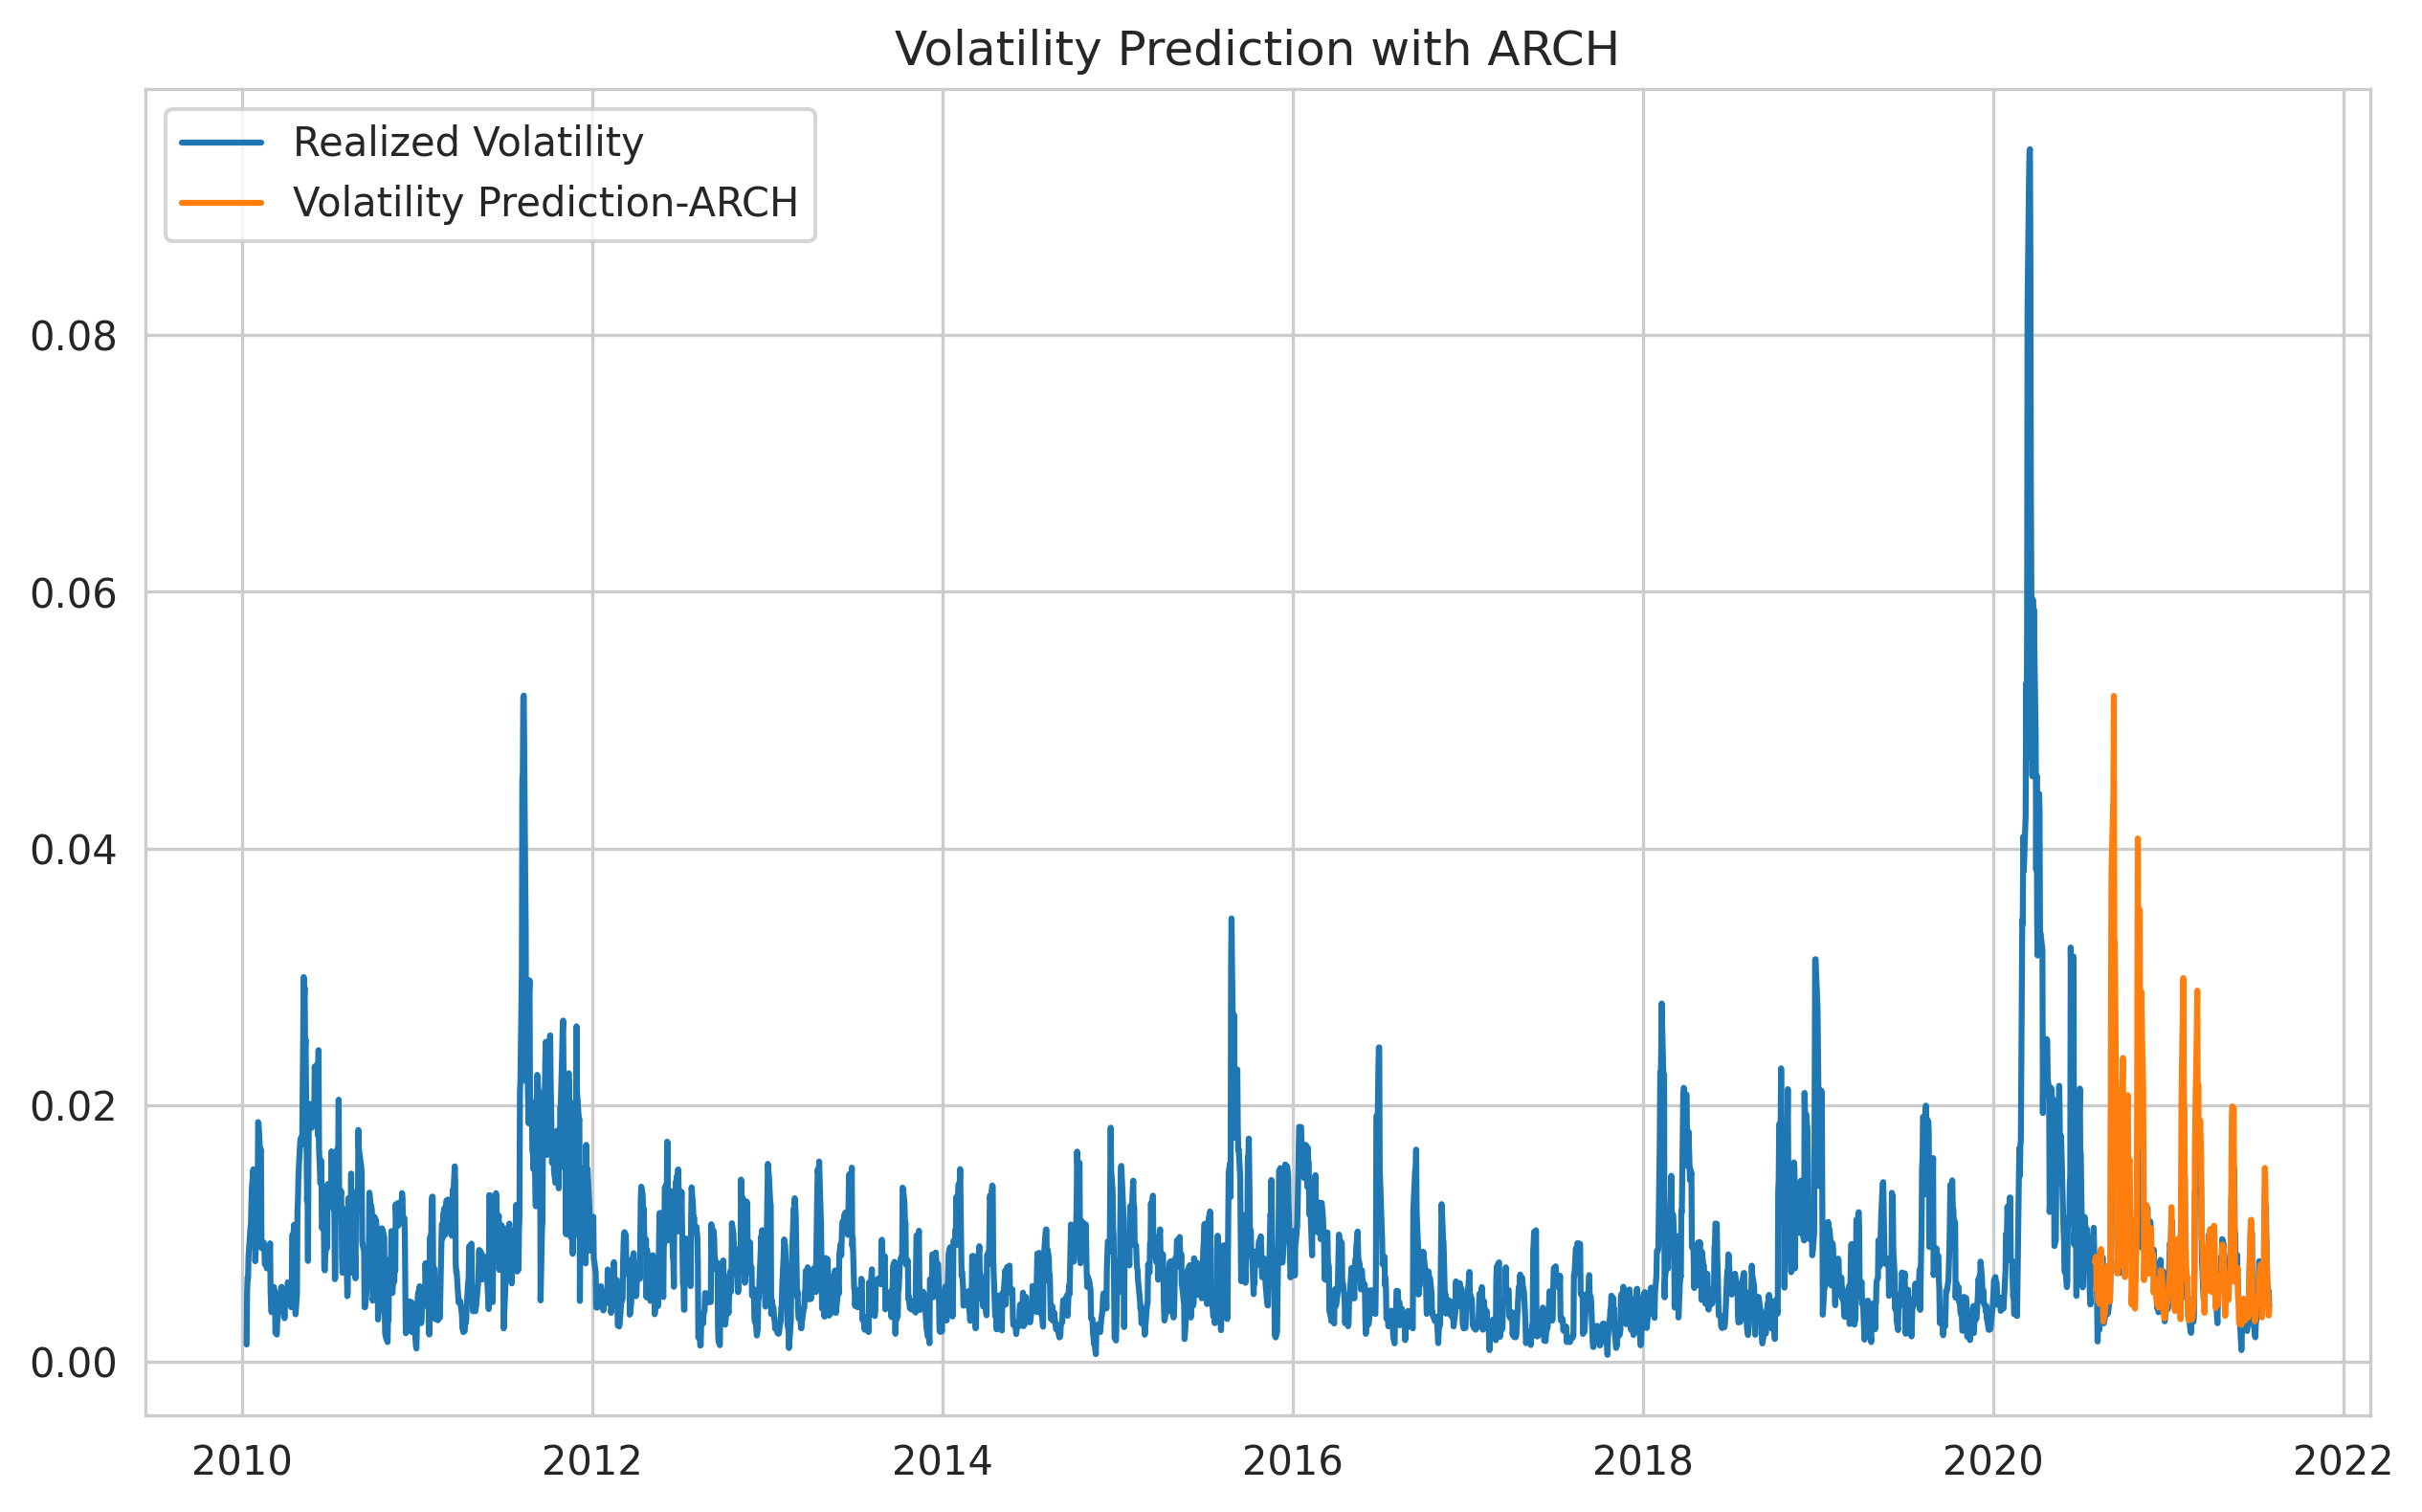

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

## GARCH


In [71]:
a0 = 0.0001
sgm2 = ret.var()
K = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(K * (1 - h ** 2) / (2.0 * (K + 3)))
beta = np.abs(h - omega)
omega = (1 - alpha) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print(f'Initial parameters for omega, alpha, and beta are \n{omega}\n{alpha}\n{beta}')


Initial parameters for omega, alpha, and beta are 
0.5791225604292787
0.5130099184547643
0.026635632698685408


In [72]:
retv

array([ 0.31156756,  0.05455206,  0.40012019, ..., -0.01862619,
        0.4206153 , -0.54060481])

In [73]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega, alpha, beta = initial_parameters
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks

logliks = garch_likelihood(initial_parameters, retv)
print(f'The Log likelihood is {logliks:.4f}')


The Log likelihood is 1341.0948


In [74]:
def garch_constraint(initial_parameters):  
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [76]:
def opt_paramsG(initial_parameters, retv):
    bounds = [(0, 1), (0, 1), (0, 1)]
    constraints = {'type': 'ineq', 'fun': lambda x: 1 - x[1] - x[2]}
    opt_result = opt.minimize(garch_likelihood, x0=initial_parameters,
                              bounds=bounds, constraints=constraints,
                              args=(retv), method='Nelder-Mead',
                              options={'maxiter': 5000})
    params = opt_result.x
    print('-' * 35)
    print('Results of Nelder-Mead minimization\n{}'.format(opt_result))
    print('-' * 35)
    print('Resulting parameters = {}'.format(params))
    return params


In [77]:
params = opt_paramsG(initial_parameters, retv)

-----------------------------------
Results of Nelder-Mead minimization
 final_simplex: (array([[0.03925689, 0.17444247, 0.78936593],
       [0.03927486, 0.17448077, 0.78932791],
       [0.03928023, 0.17438039, 0.78940407],
       [0.03929598, 0.17444313, 0.78928922]]), array([978.43816356, 978.43816826, 978.43819134, 978.43819154]))
           fun: 978.4381635610393
       message: 'Optimization terminated successfully.'
          nfev: 169
           nit: 95
        status: 0
       success: True
             x: array([0.03925689, 0.17444247, 0.78936593])
-----------------------------------
Resulting parameters = [0.03925689 0.17444247 0.78936593]


In [78]:
from numba import jit

@jit(nopython=True, parallel=True)
def garch_apply(ret, omega, alpha, beta):
    T = len(ret)
    sigma2 = np.zeros(T + 1)
    sigma2[0] = np.var(ret)
    for t in range(1, T):
        sigma2[t] = omega + alpha * ret[t - 1] ** 2 + beta * sigma2[t-1]
    return sigma2


In [79]:
garch = arch_model(ret, mean='zero', vol='GARCH', p=1, o=0, q=1)\
        .fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Mon, Apr 10 2023   Df Residuals:                     2913
Time:                        00:26:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [80]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
        .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                Mon, Apr 10 2023   Df Residuals:                     2913
Time:                        00:27:13   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [83]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,np.sqrt(forecast_garch.variance.iloc[-len(split_date):] 
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0878


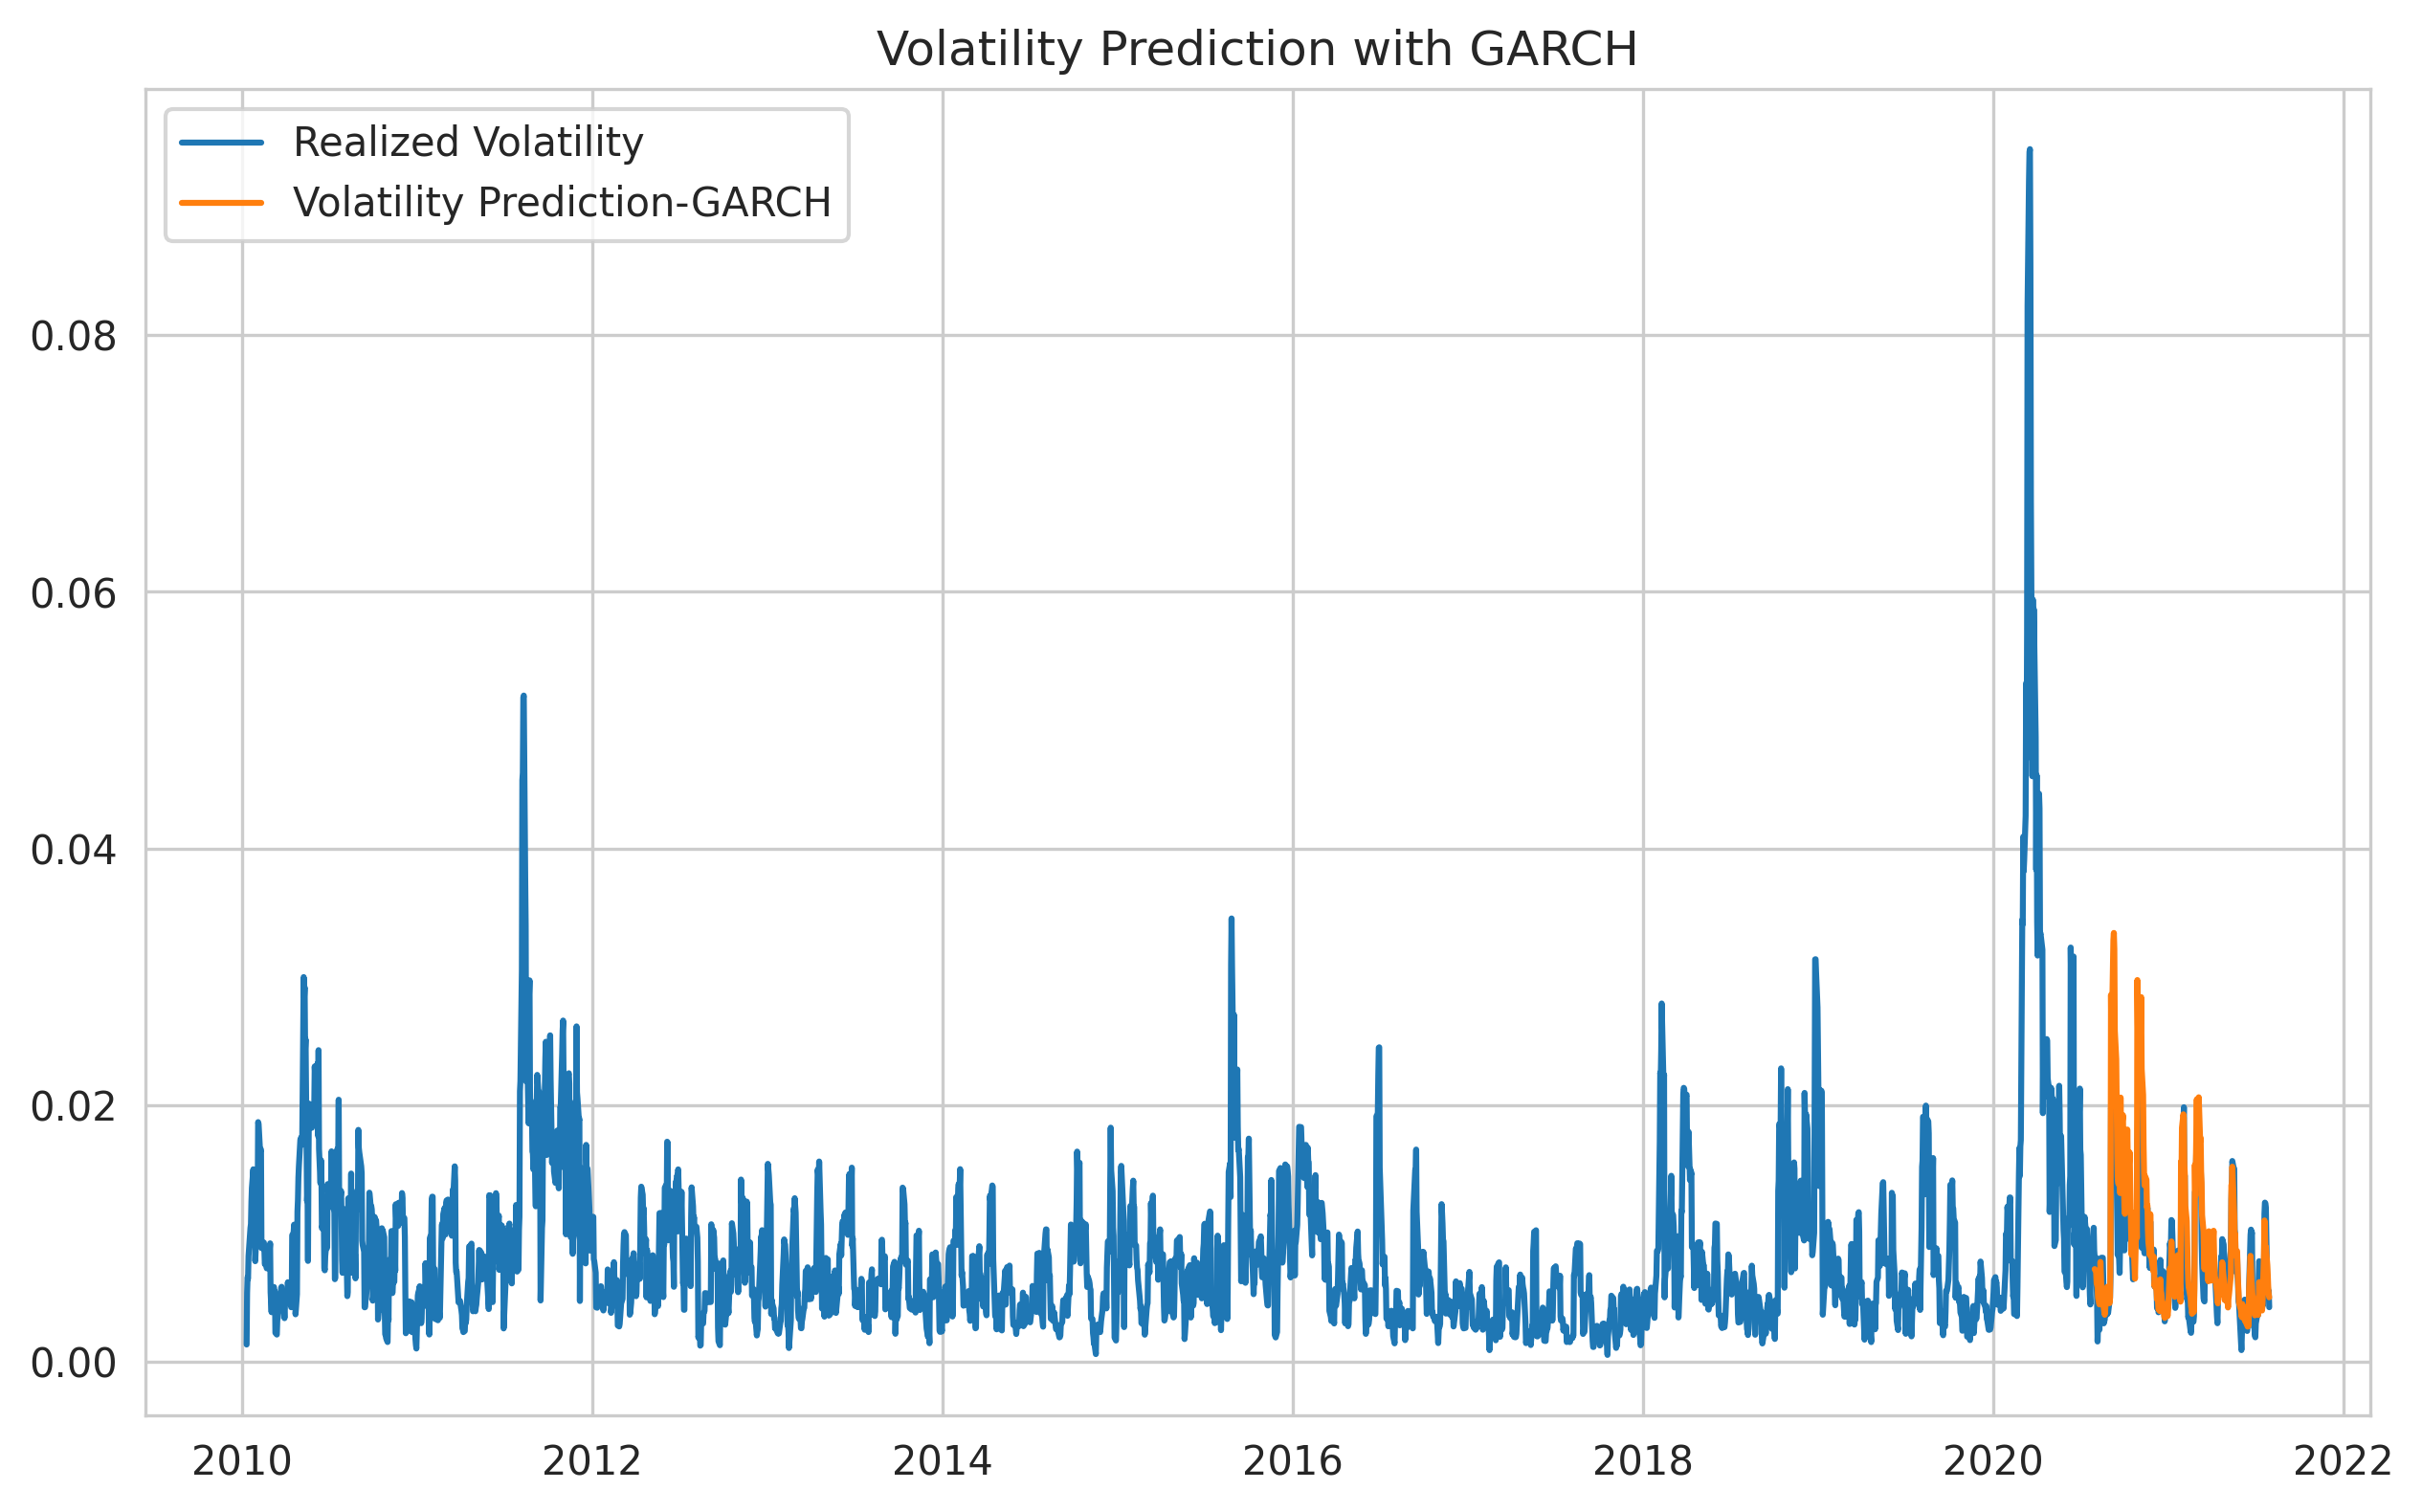

In [86]:
plt.figure(figsize=(10,6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100, 
         label='Volatility Prediction-GARCH')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

### GJR-GARCH model and EGARCH model

The RMSE value of GJR-GARCH models is 0.0882
The RMSE value of EGARCH models is 0.0904


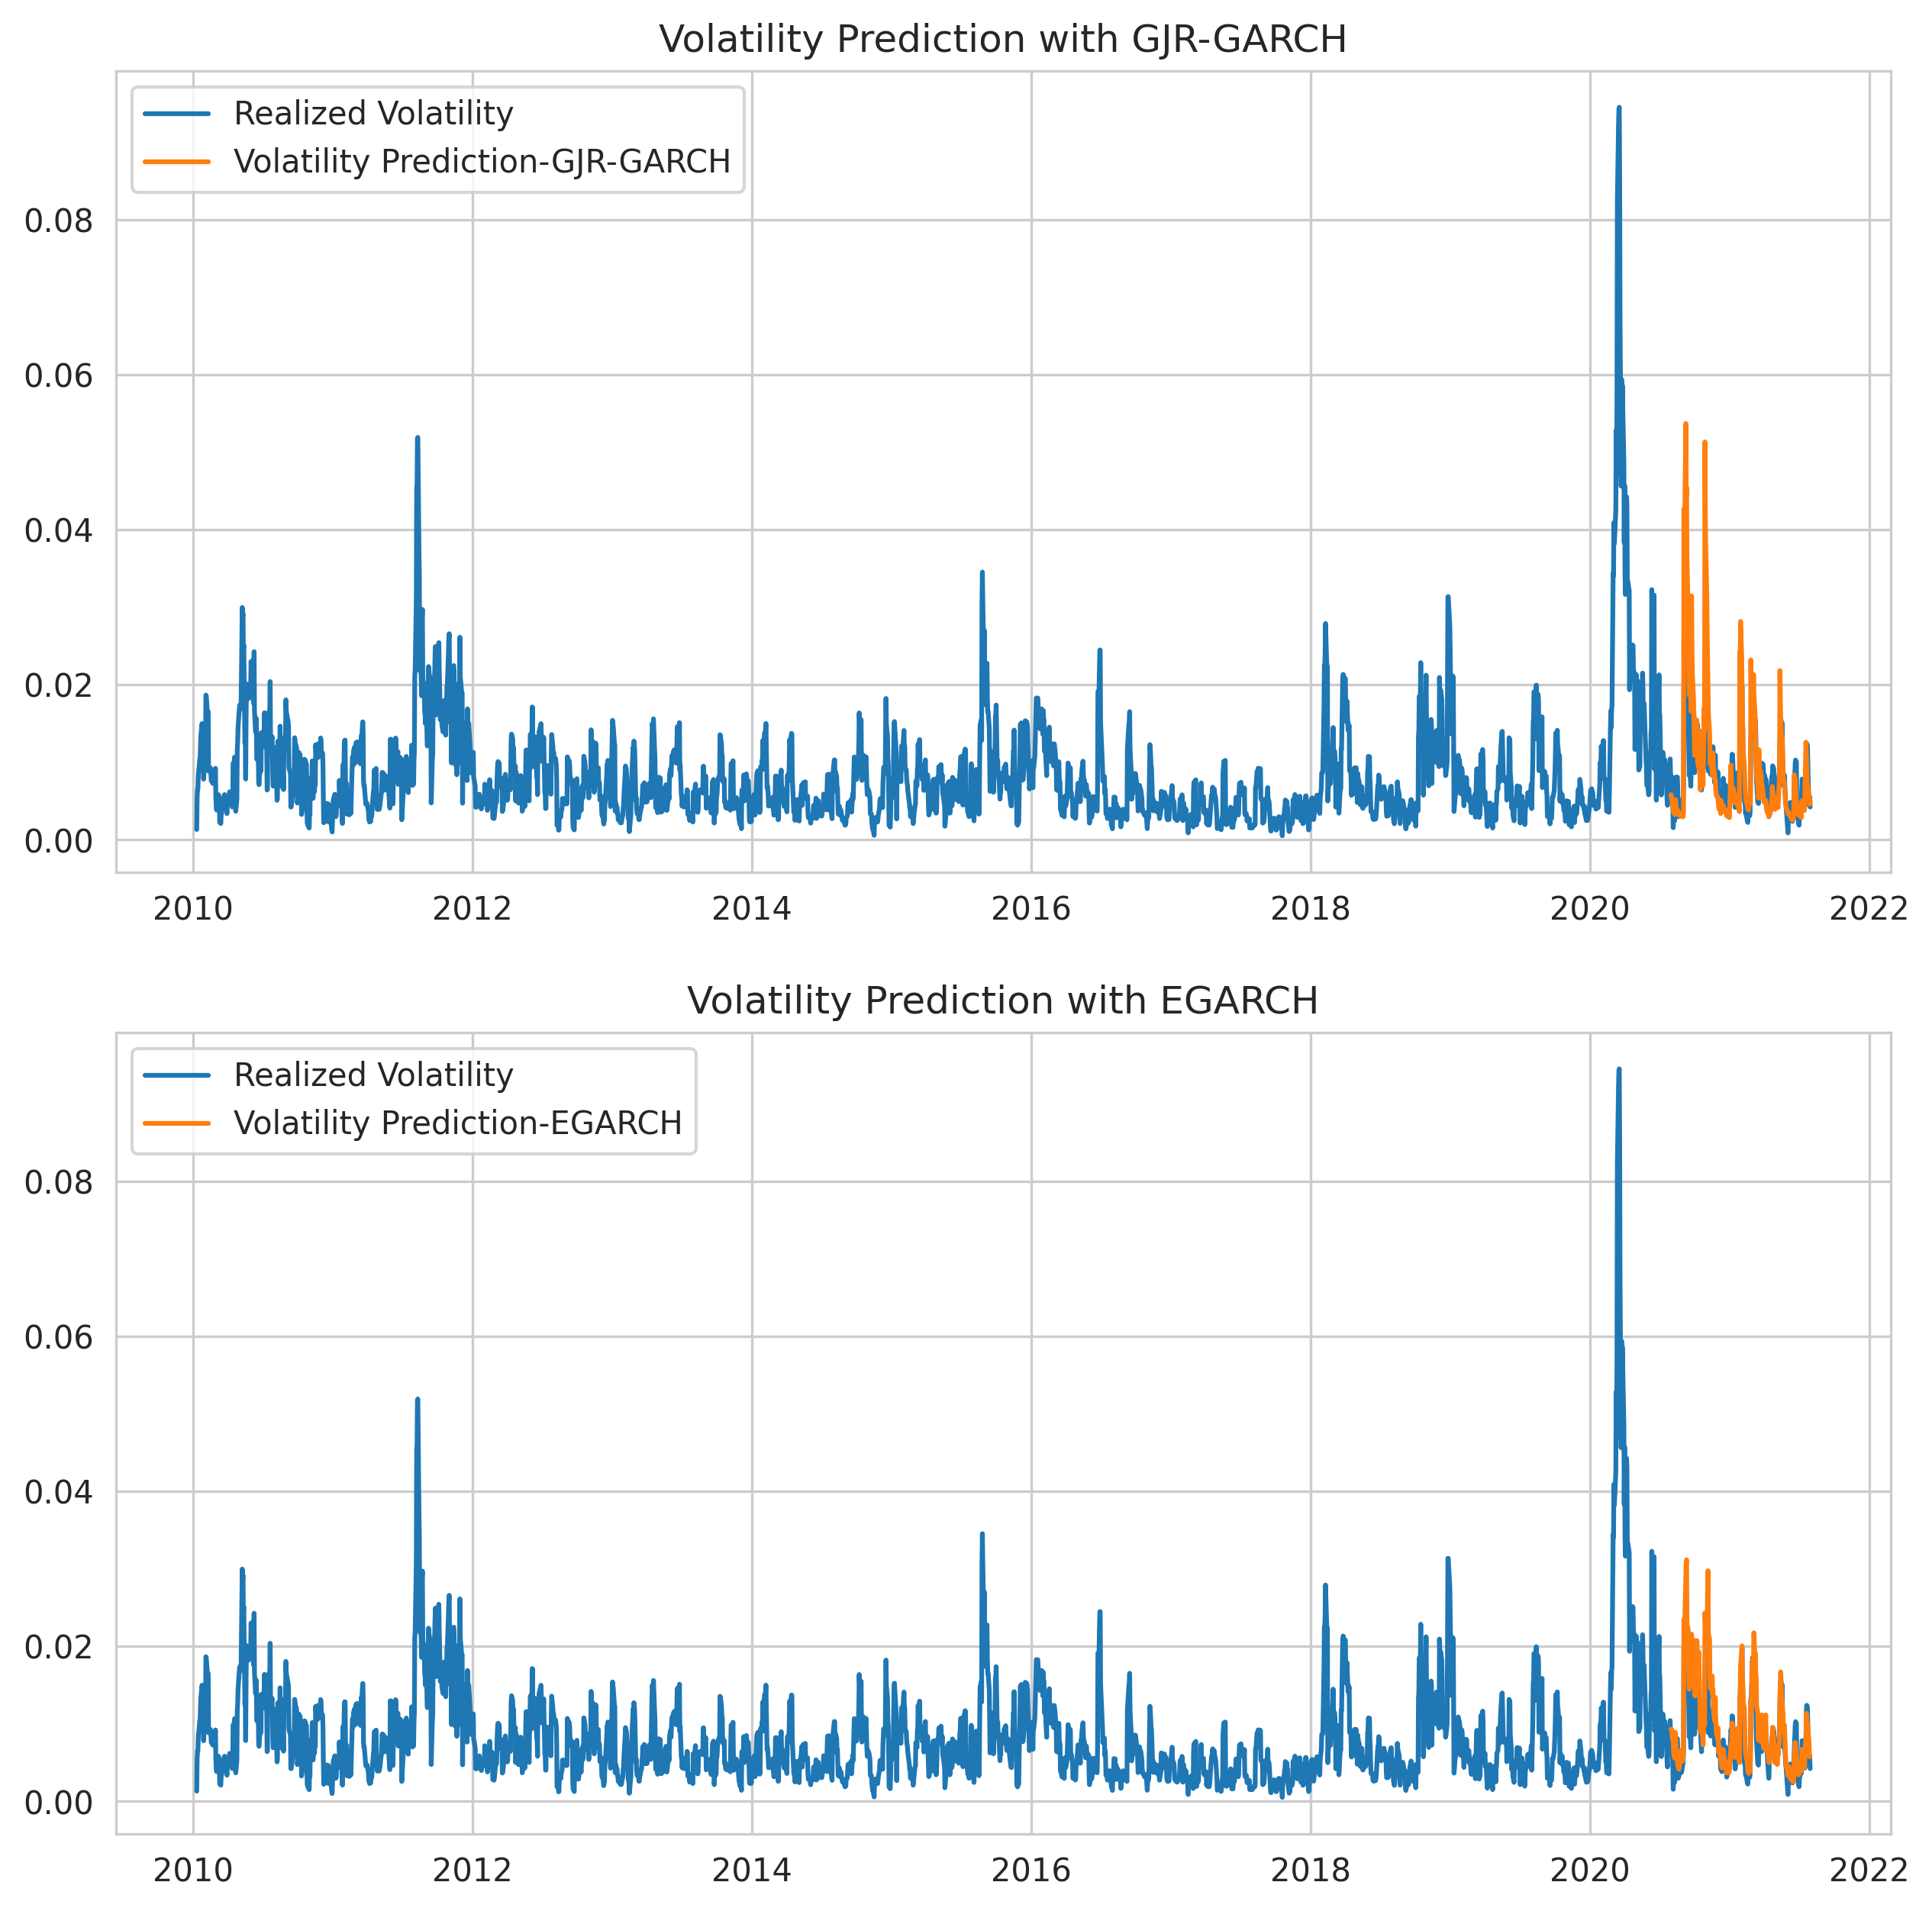

In [95]:
# GJR-GARCH model
bic_gjr_garch = []
for p in range(1, 5):
    for q in range(1, 5):
        gjrgarch = arch_model(ret, mean='zero', p=p, o=1, q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param = p, q
gjrgarch = arch_model(ret,mean='zero', p=best_param[0], o=1, q=best_param[1]).fit(disp='off')
forecast_gjrgarch = gjrgarch.forecast(start=split_date[0])
rmse_gjr_garch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of GJR-GARCH models is {:.4f}'.format(rmse_gjr_garch))

# EGARCH model
bic_egarch = []
for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH', p=best_param[0], q=best_param[1]).fit(disp='off')
forecast_egarch = egarch.forecast(start=split_date[0])
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100, np.sqrt(forecast_egarch.variance.iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

# Plot the results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# GJR-GARCH plot
axes[0].plot(realized_vol / 100, label='Realized Volatility')
axes[0].plot(forecast_gjrgarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GJR-GARCH')
axes[0].set_title('Volatility Prediction with GJR-GARCH', fontsize=12)
axes[0].legend()

# EGARCH plot
axes[1].plot(realized_vol / 100, label='Realized Volatility')
axes[1].plot(forecast_egarch.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-EGARCH')
axes[1].set_title('Volatility Prediction with EGARCH', fontsize=12)
axes[1].legend()


## SVR-GARCH -Linear, RBF and Poly

In [ ]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [103]:
realized_vol = pd.DataFrame(ret.rolling(5).std()).reset_index(drop=True)

In [104]:
returns_svm = ret ** 2; returns_svm = returns_svm.reset_index().drop('Date', axis=1)

In [105]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)[4:].reset_index(drop=True)

In [106]:
realized_vol = realized_vol.dropna().reset_index(drop=True)

In [107]:
svr_poly, svr_lin, svr_rbf = SVR(kernel='poly', degree=2), SVR(kernel='linear'), SVR(kernel='rbf')

In [108]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n], realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])
clf = RandomizedSearchCV(svr_rbf, para_grid)
clf.fit(X.iloc[:-n], realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf.predict(X.iloc[-n:])

In [112]:
predict_svr_lin = pd.DataFrame(predict_svr_lin, index=ret.iloc[-n:].index)
predict_svr_rbf = pd.DataFrame(predict_svr_rbf, index=ret.iloc[-n:].index)

rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))

print(f'The RMSE value of SVR with Linear Kernel is {rmse_svr:.6f}')
print(f'The RMSE value of SVR with RBF Kernel is  {rmse_svr_rbf:.6f}')


The RMSE value of SVR with Linear Kernel is 0.000464
The RMSE value of SVR with RBF Kernel is  0.000607


In [113]:
realized_vol.index = ret.iloc[4:].index

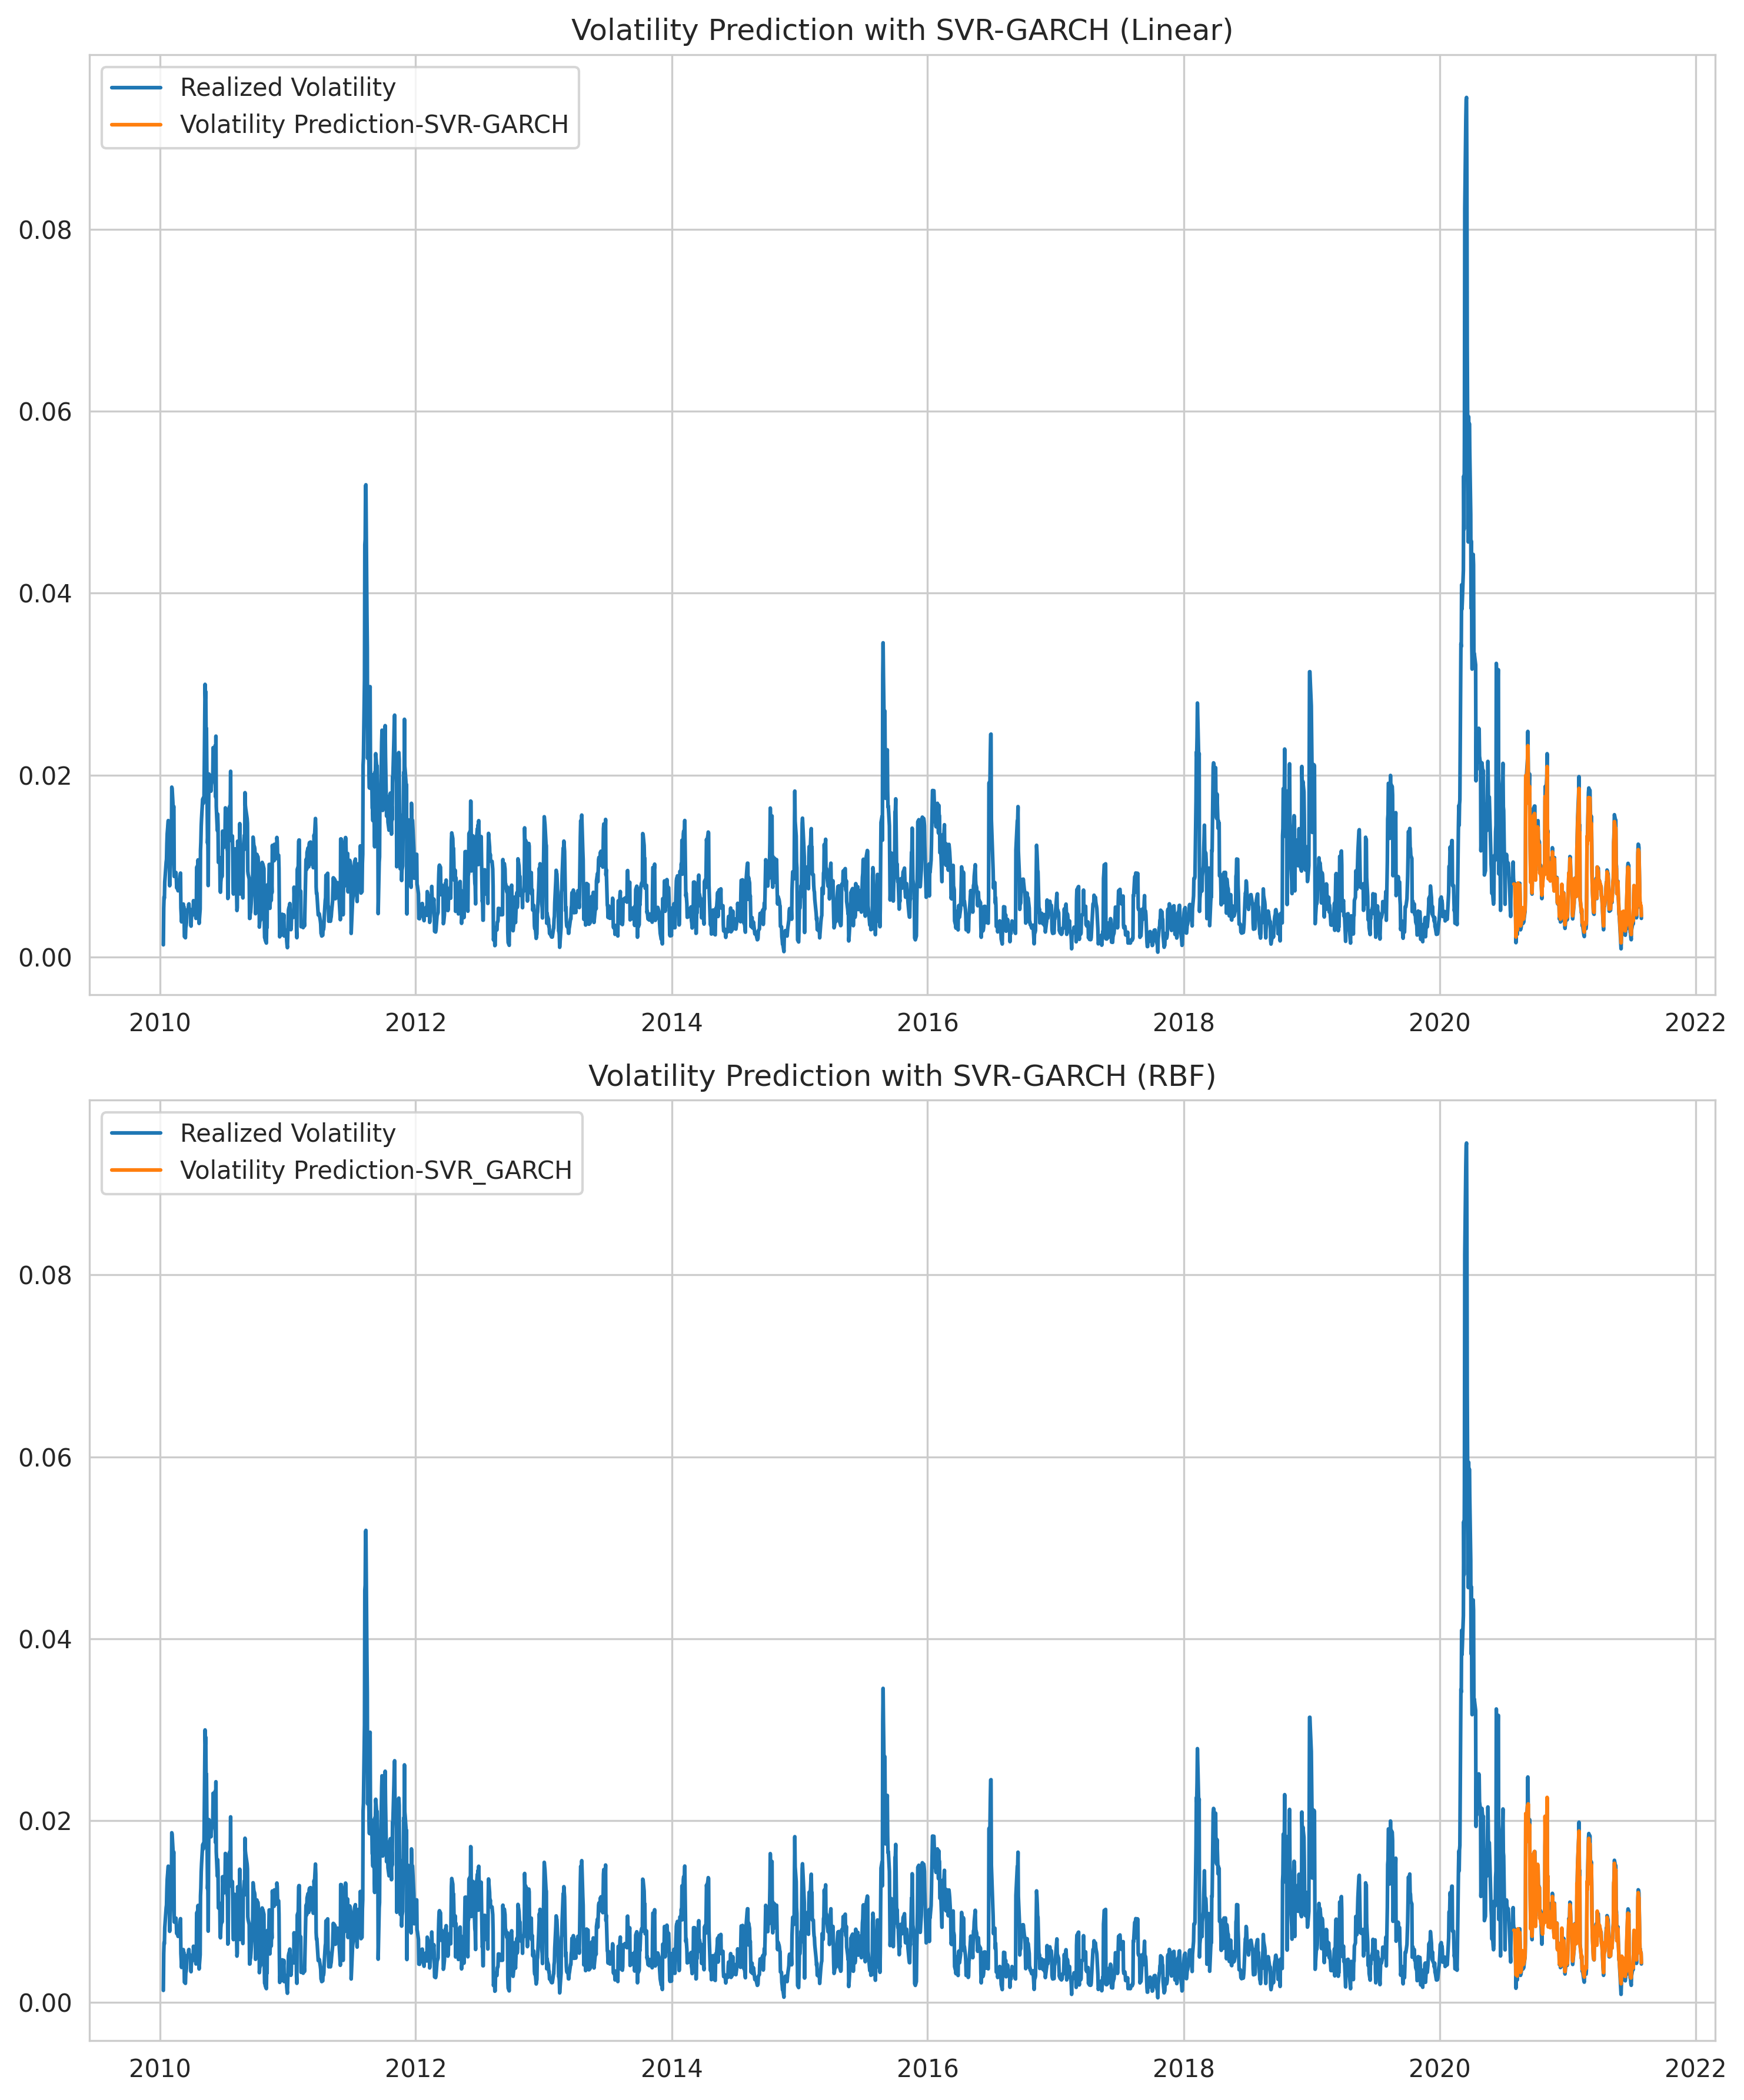

In [114]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

axes[0].plot(realized_vol / 100, label='Realized Volatility')
axes[0].plot(predict_svr_lin / 100, label='Volatility Prediction-SVR-GARCH')
axes[0].set_title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
axes[0].legend()

axes[1].plot(realized_vol / 100, label='Realized Volatility')
axes[1].plot(predict_svr_rbf / 100, label='Volatility Prediction-SVR_GARCH')
axes[1].set_title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()


In [228]:
param_dist = {'gamma': sp_rand(),
              'C': sp_rand(),
              'epsilon': sp_rand()}
n_iter_search = 5
clf = RandomizedSearchCV(estimator=svr_poly, param_distributions=param_dist,
                         n_iter=n_iter_search)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.ravel())
predict_svr_poly = clf.predict(X.iloc[-n:])


In [229]:
predict_svr_poly = pd.DataFrame(predict_svr_poly)
predict_svr_poly.index = ret.iloc[-n:].index
rmse_svr_poly = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                            predict_svr_poly / 100))
print('The RMSE value of SVR with Polynomial Kernel is {:.6f}'\
      .format(rmse_svr_poly))

The RMSE value of SVR with Polynomial Kernel is 0.002993


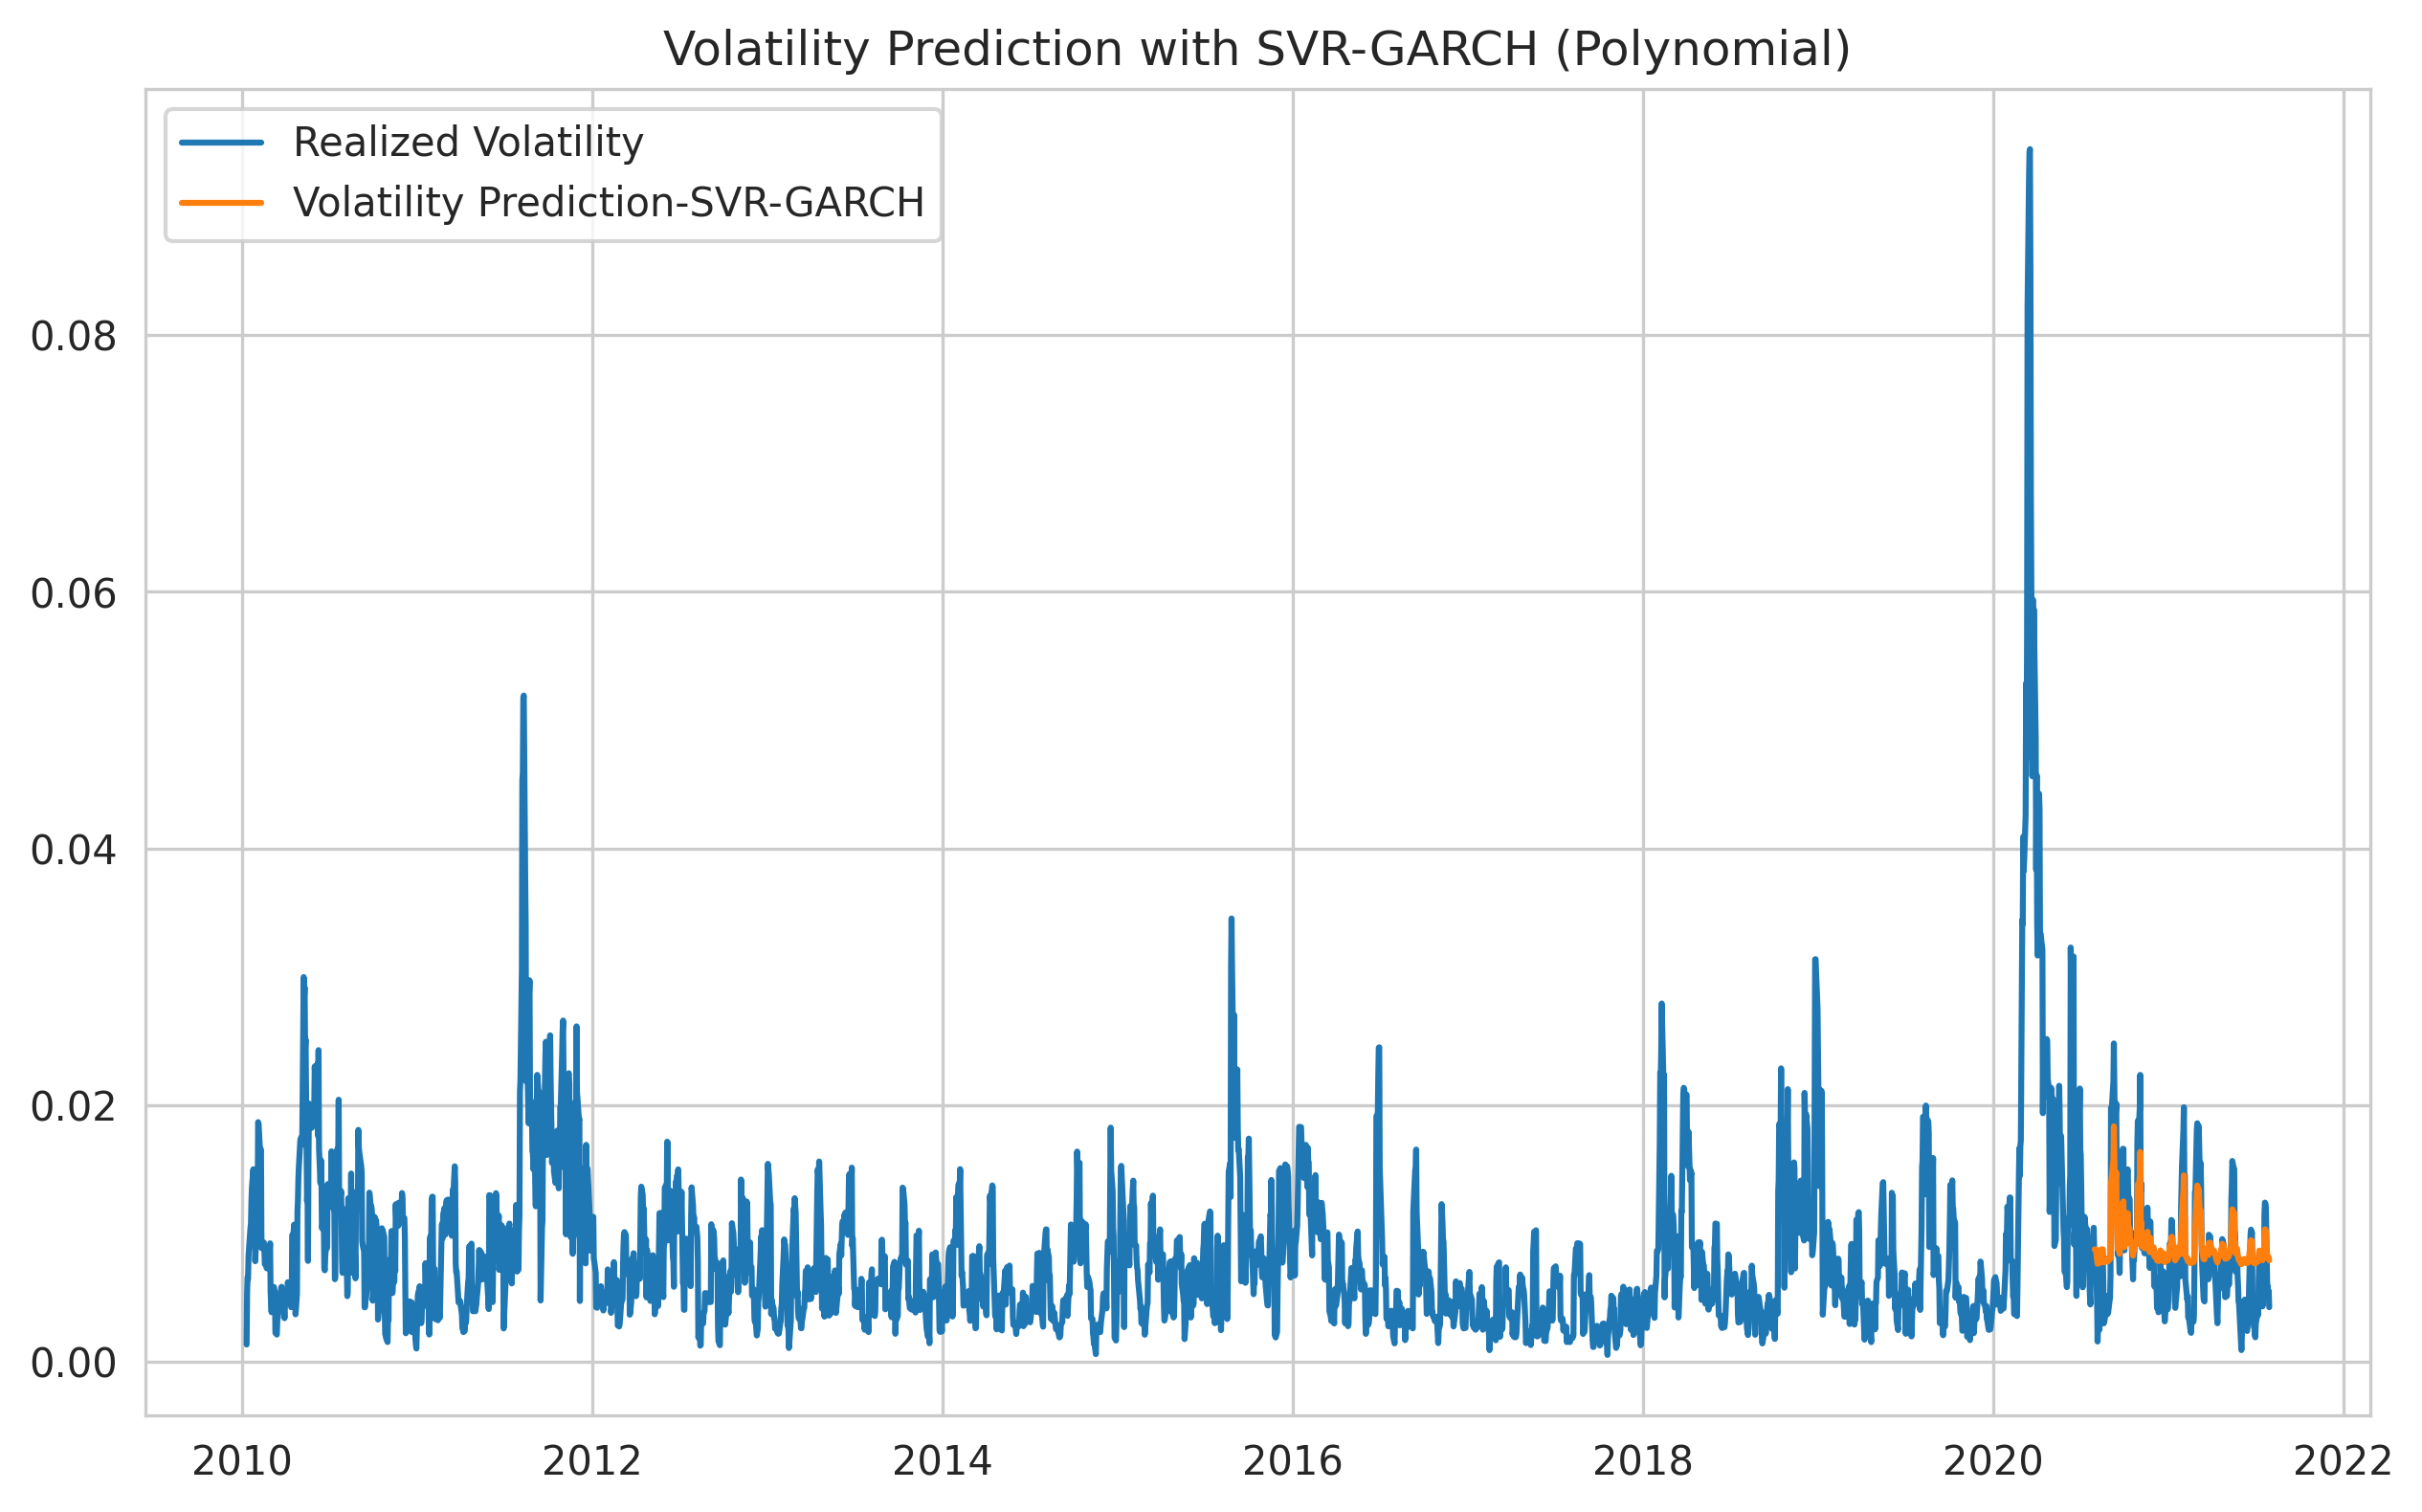

In [230]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol/100, label='Realized Volatility')
plt.plot(predict_svr_poly/100, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Polynomial)',
          fontsize=12)
plt.legend()
plt.show()

## MLP-GARCH, DEEP LEARNING-GARCH

In [132]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1) 

para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
               'max_iter': [500, 1000],
               'alpha': [0.00005, 0.0005]}

clf = RandomizedSearchCV(NN_vol, para_grid_NN)
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])
NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index
rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100,NN_predictions / 100))
print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

model = keras.Sequential(
    [layers.Dense(256, activation="relu"),
     layers.Dense(128, activation="relu"),
     layers.Dense(1, activation="linear"),])

model.compile(loss='mse', optimizer='rmsprop')

epochs_trial = np.arange(100, 400, 4)
batch_trial = np.arange(100, 400, 4)
DL_pred = []
DL_RMSE = []

for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] / 100, DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))
    
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

The RMSE value of NN is 0.000647
8/8 [==============================] - 0s 2ms/step
DL_RMSE_1:0.000529
8/8 [==============================] - 0s 1ms/step
DL_RMSE_2:0.000552
8/8 [==============================] - 0s 1ms/step
DL_RMSE_3:0.000741
8/8 [==============================] - 0s 1ms/step
DL_RMSE_4:0.000620


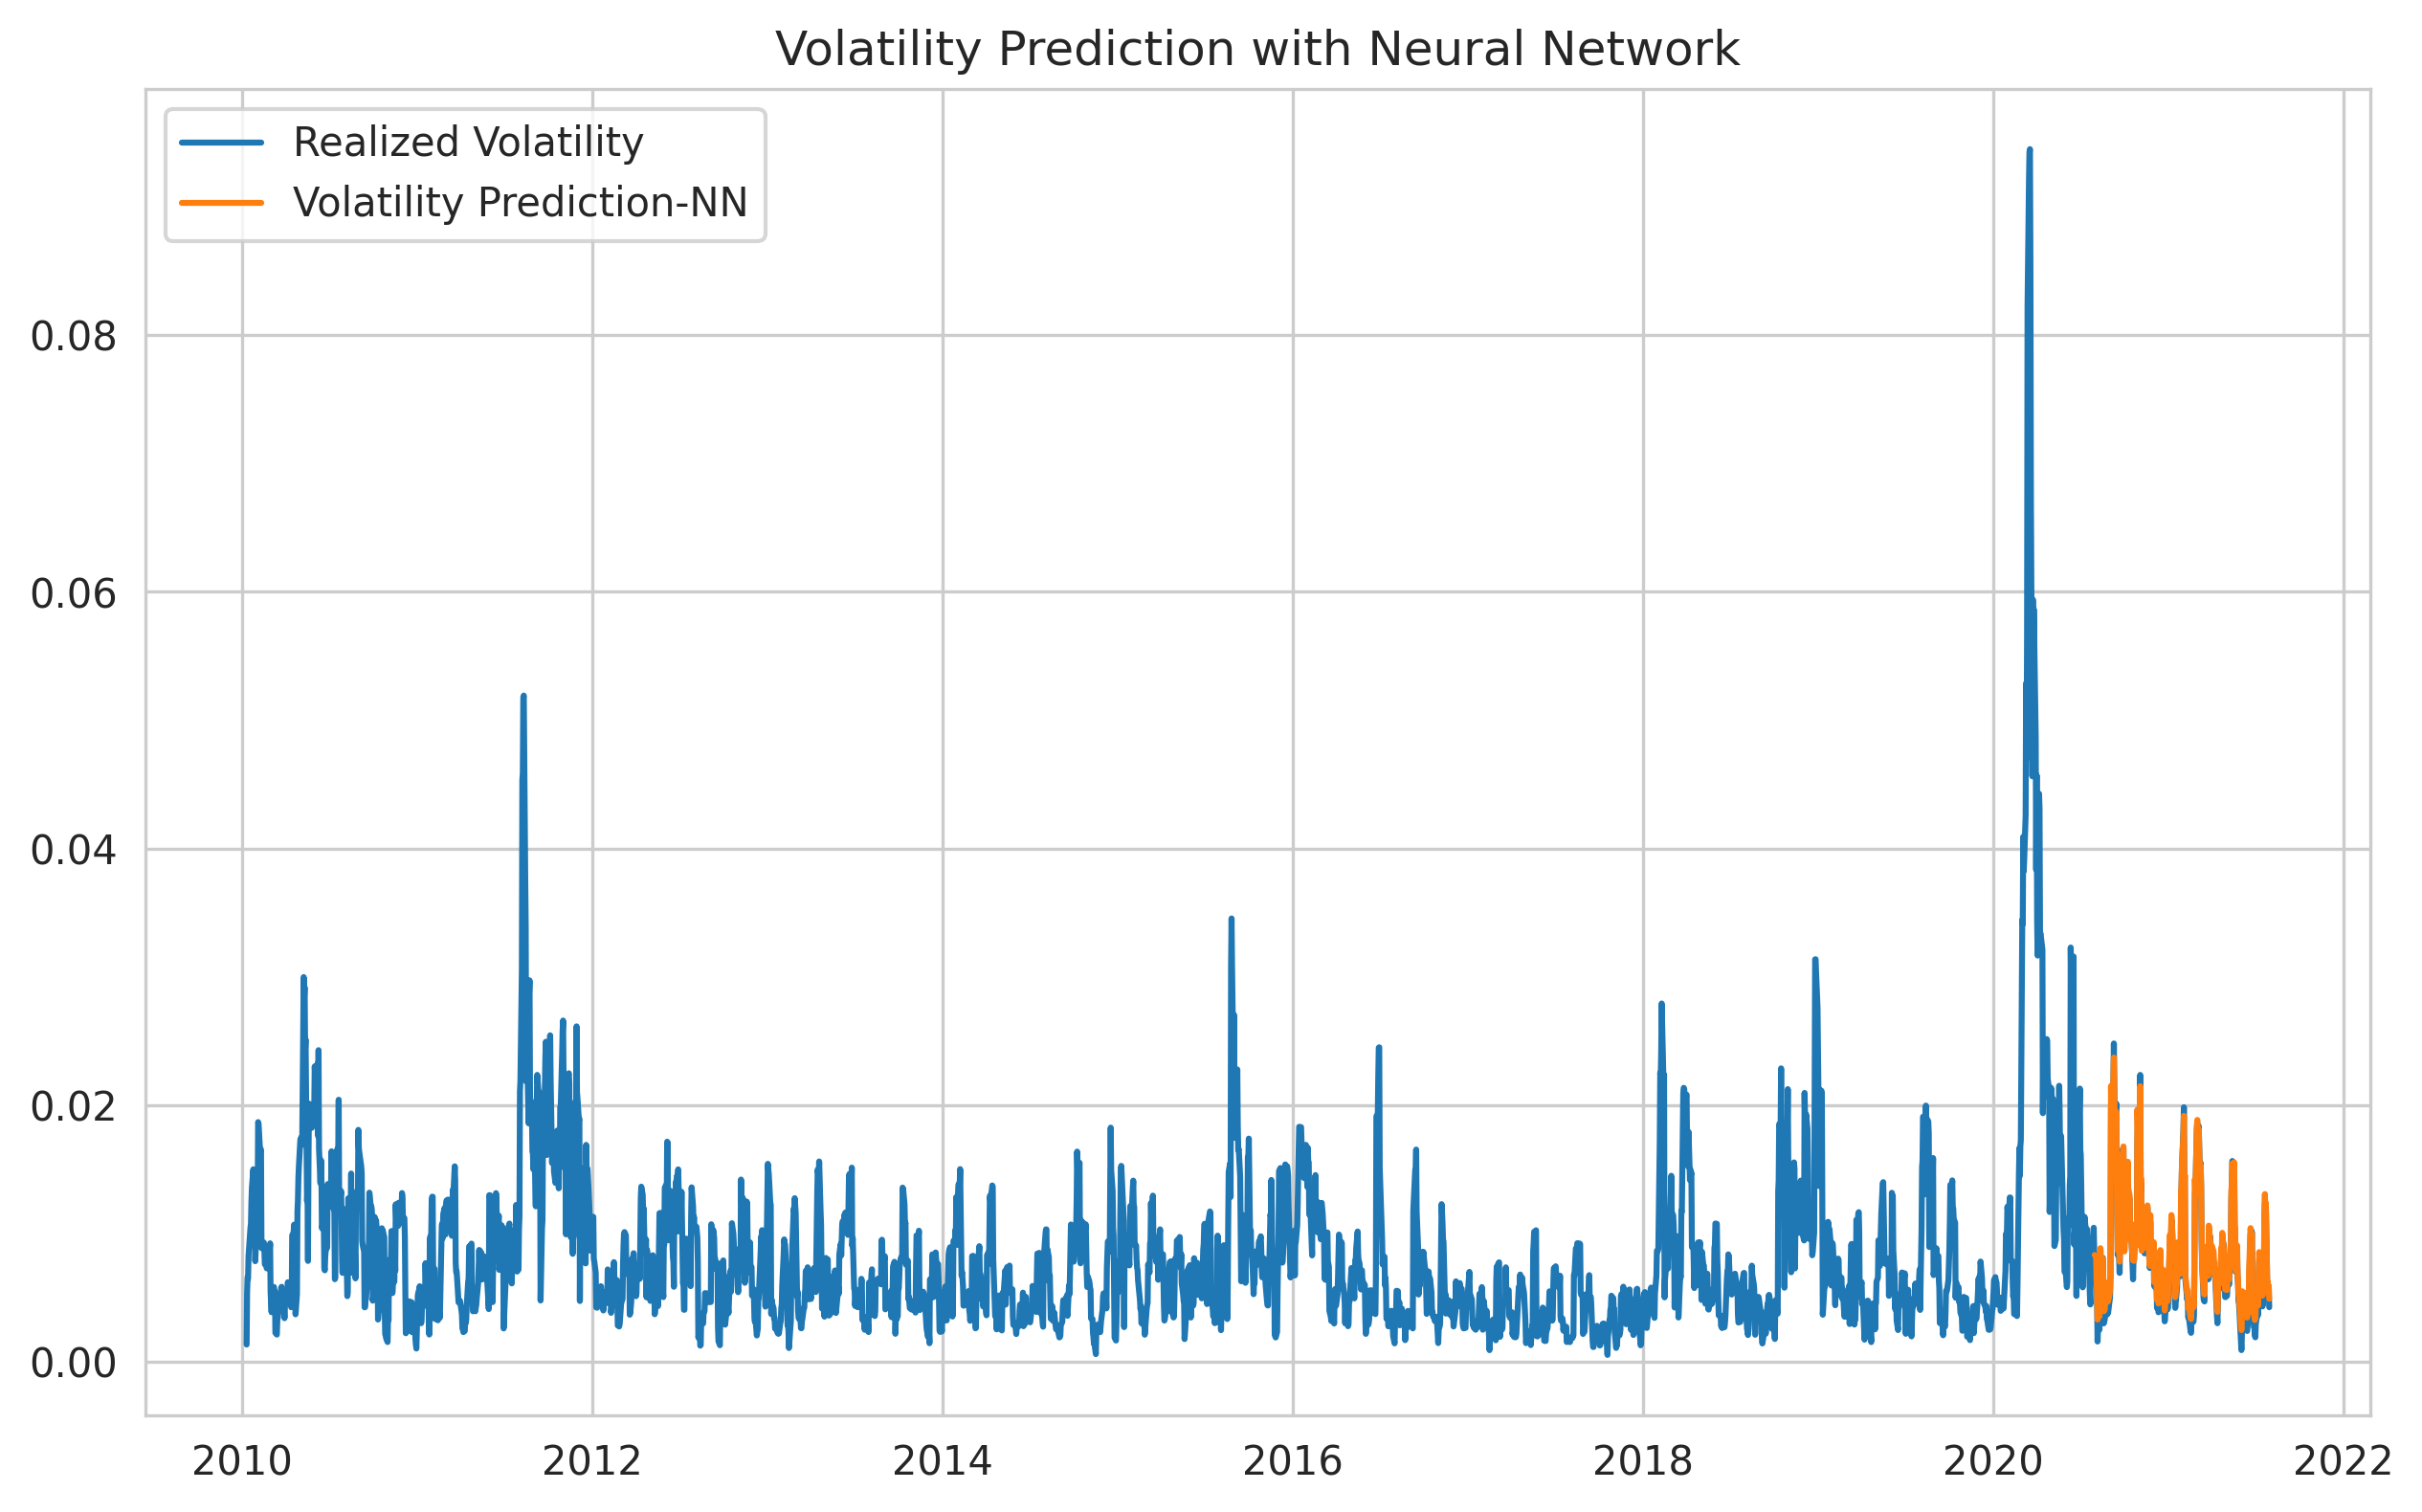

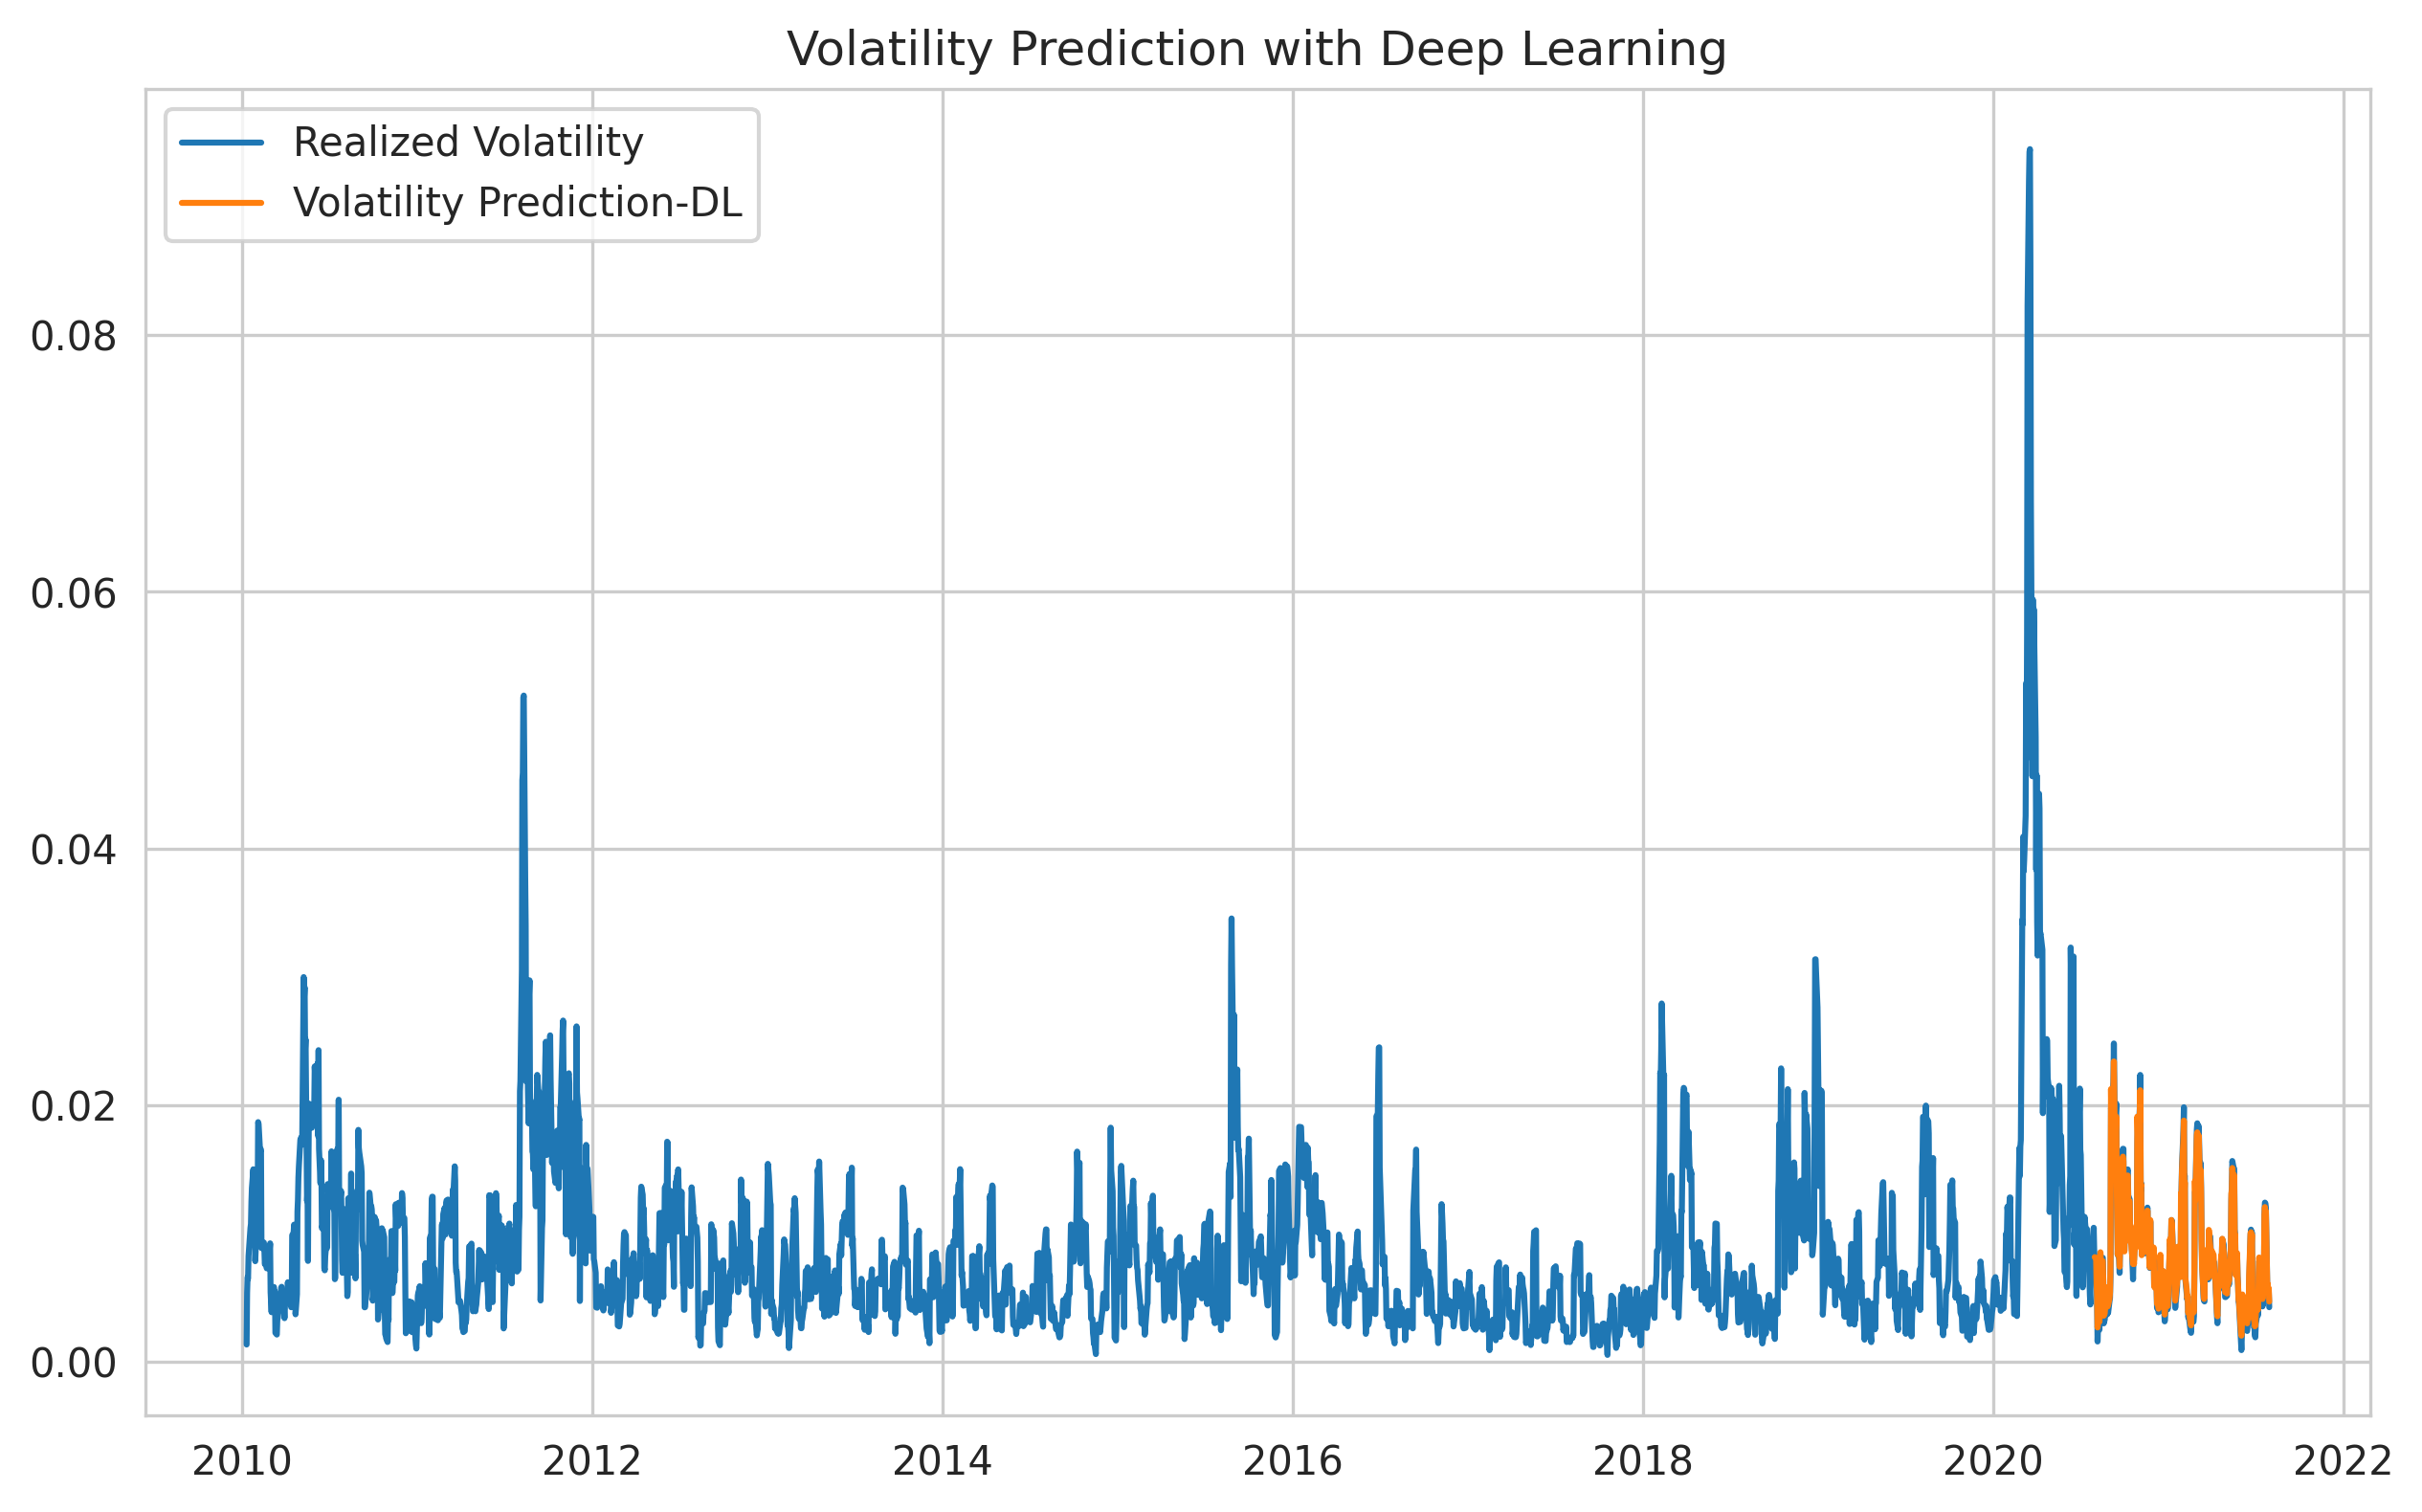

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,label='Realized Volatility')
plt.plot(DL_predict / 100,label='Volatility Prediction-DL')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()